# Mašinsko učenje - projekat 2
## Petra Milosavljević 1582
Korišćen dataset: https://www.kaggle.com/datasets/kartikeybartwal/ecommerce-product-recommendation-collaborative

### Biblioteke

In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics, cluster, datasets
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.neighbors import kneighbors_graph
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

import warnings

pd.options.display.max_columns = None
warnings.filterwarnings("ignore", category=FutureWarning)

### Učitavanje dataseta i provera osnovnih informacija

In [2]:
df = pd.read_csv('user_personalized_features.csv')
df.head()

,Unnamed: 0,User_ID,Age,Gender,Location,Income,Interests,Last_Login_Days_Ago,Purchase_Frequency,Average_Order_Value,Total_Spending,Product_Category_Preference,Time_Spent_on_Site_Minutes,Pages_Viewed,Newsletter_Subscription
0,0,#1,56,Male,Suburban,38037,Sports,5,7,18,2546,Books,584,38,True
1,1,#2,46,Female,Rural,103986,Technology,15,7,118,320,Electronics,432,40,False
2,2,#3,32,Female,Suburban,101942,Sports,28,1,146,3766,Apparel,306,1,True
3,3,#4,60,Female,Suburban,71612,Fashion,18,3,163,4377,Apparel,527,29,False
4,4,#5,25,Male,Suburban,49725,Travel,2,5,141,4502,Health & Beauty,53,10,True


In [3]:
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['User_ID'], axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Age                          1000 non-null   int64 
 1   Gender                       1000 non-null   object
 2   Location                     1000 non-null   object
 3   Income                       1000 non-null   int64 
 4   Interests                    1000 non-null   object
 5   Last_Login_Days_Ago          1000 non-null   int64 
 6   Purchase_Frequency           1000 non-null   int64 
 7   Average_Order_Value          1000 non-null   int64 
 8   Total_Spending               1000 non-null   int64 
 9   Product_Category_Preference  1000 non-null   object
 10  Time_Spent_on_Site_Minutes   1000 non-null   int64 
 11  Pages_Viewed                 1000 non-null   int64 
 12  Newsletter_Subscription      1000 non-null   bool  
dtypes: bool(1), int64(8), object(4)
me

In [5]:
numerical = df.select_dtypes(include='int64').columns.tolist()
categorical = df.select_dtypes(include=['object', 'bool']).columns.tolist()

In [6]:
df[categorical].describe()

,Gender,Location,Interests,Product_Category_Preference,Newsletter_Subscription
count,1000,1000,1000,1000,1000
unique,2,3,5,5,2
top,Male,Suburban,Sports,Apparel,True
freq,526,349,213,218,507


In [7]:
df[numerical].describe()

,Age,Income,Last_Login_Days_Ago,Purchase_Frequency,Average_Order_Value,Total_Spending,Time_Spent_on_Site_Minutes,Pages_Viewed
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,40.986000,81304.732000,15.586000,4.631000,104.039000,2552.957000,297.360000,24.40300
std,13.497852,37363.972753,8.205604,2.837762,54.873569,1420.985048,175.596123,14.02017
min,18.000000,20155.000000,1.000000,0.000000,10.000000,112.000000,2.000000,1.00000
25%,29.000000,48715.500000,8.000000,2.000000,58.000000,1271.750000,144.000000,12.00000
50%,42.000000,81042.000000,16.000000,5.000000,105.000000,2542.000000,292.500000,24.50000
75%,52.000000,112694.500000,23.000000,7.000000,150.000000,3835.500000,449.250000,36.00000
max,64.000000,149951.000000,29.000000,9.000000,199.000000,4999.000000,599.000000,49.00000


In [8]:
df.isnull().sum()

Age                            0
Gender                         0
Location                       0
Income                         0
Interests                      0
Last_Login_Days_Ago            0
Purchase_Frequency             0
Average_Order_Value            0
Total_Spending                 0
Product_Category_Preference    0
Time_Spent_on_Site_Minutes     0
Pages_Viewed                   0
Newsletter_Subscription        0
dtype: int64

In [9]:
df.duplicated().sum()

0

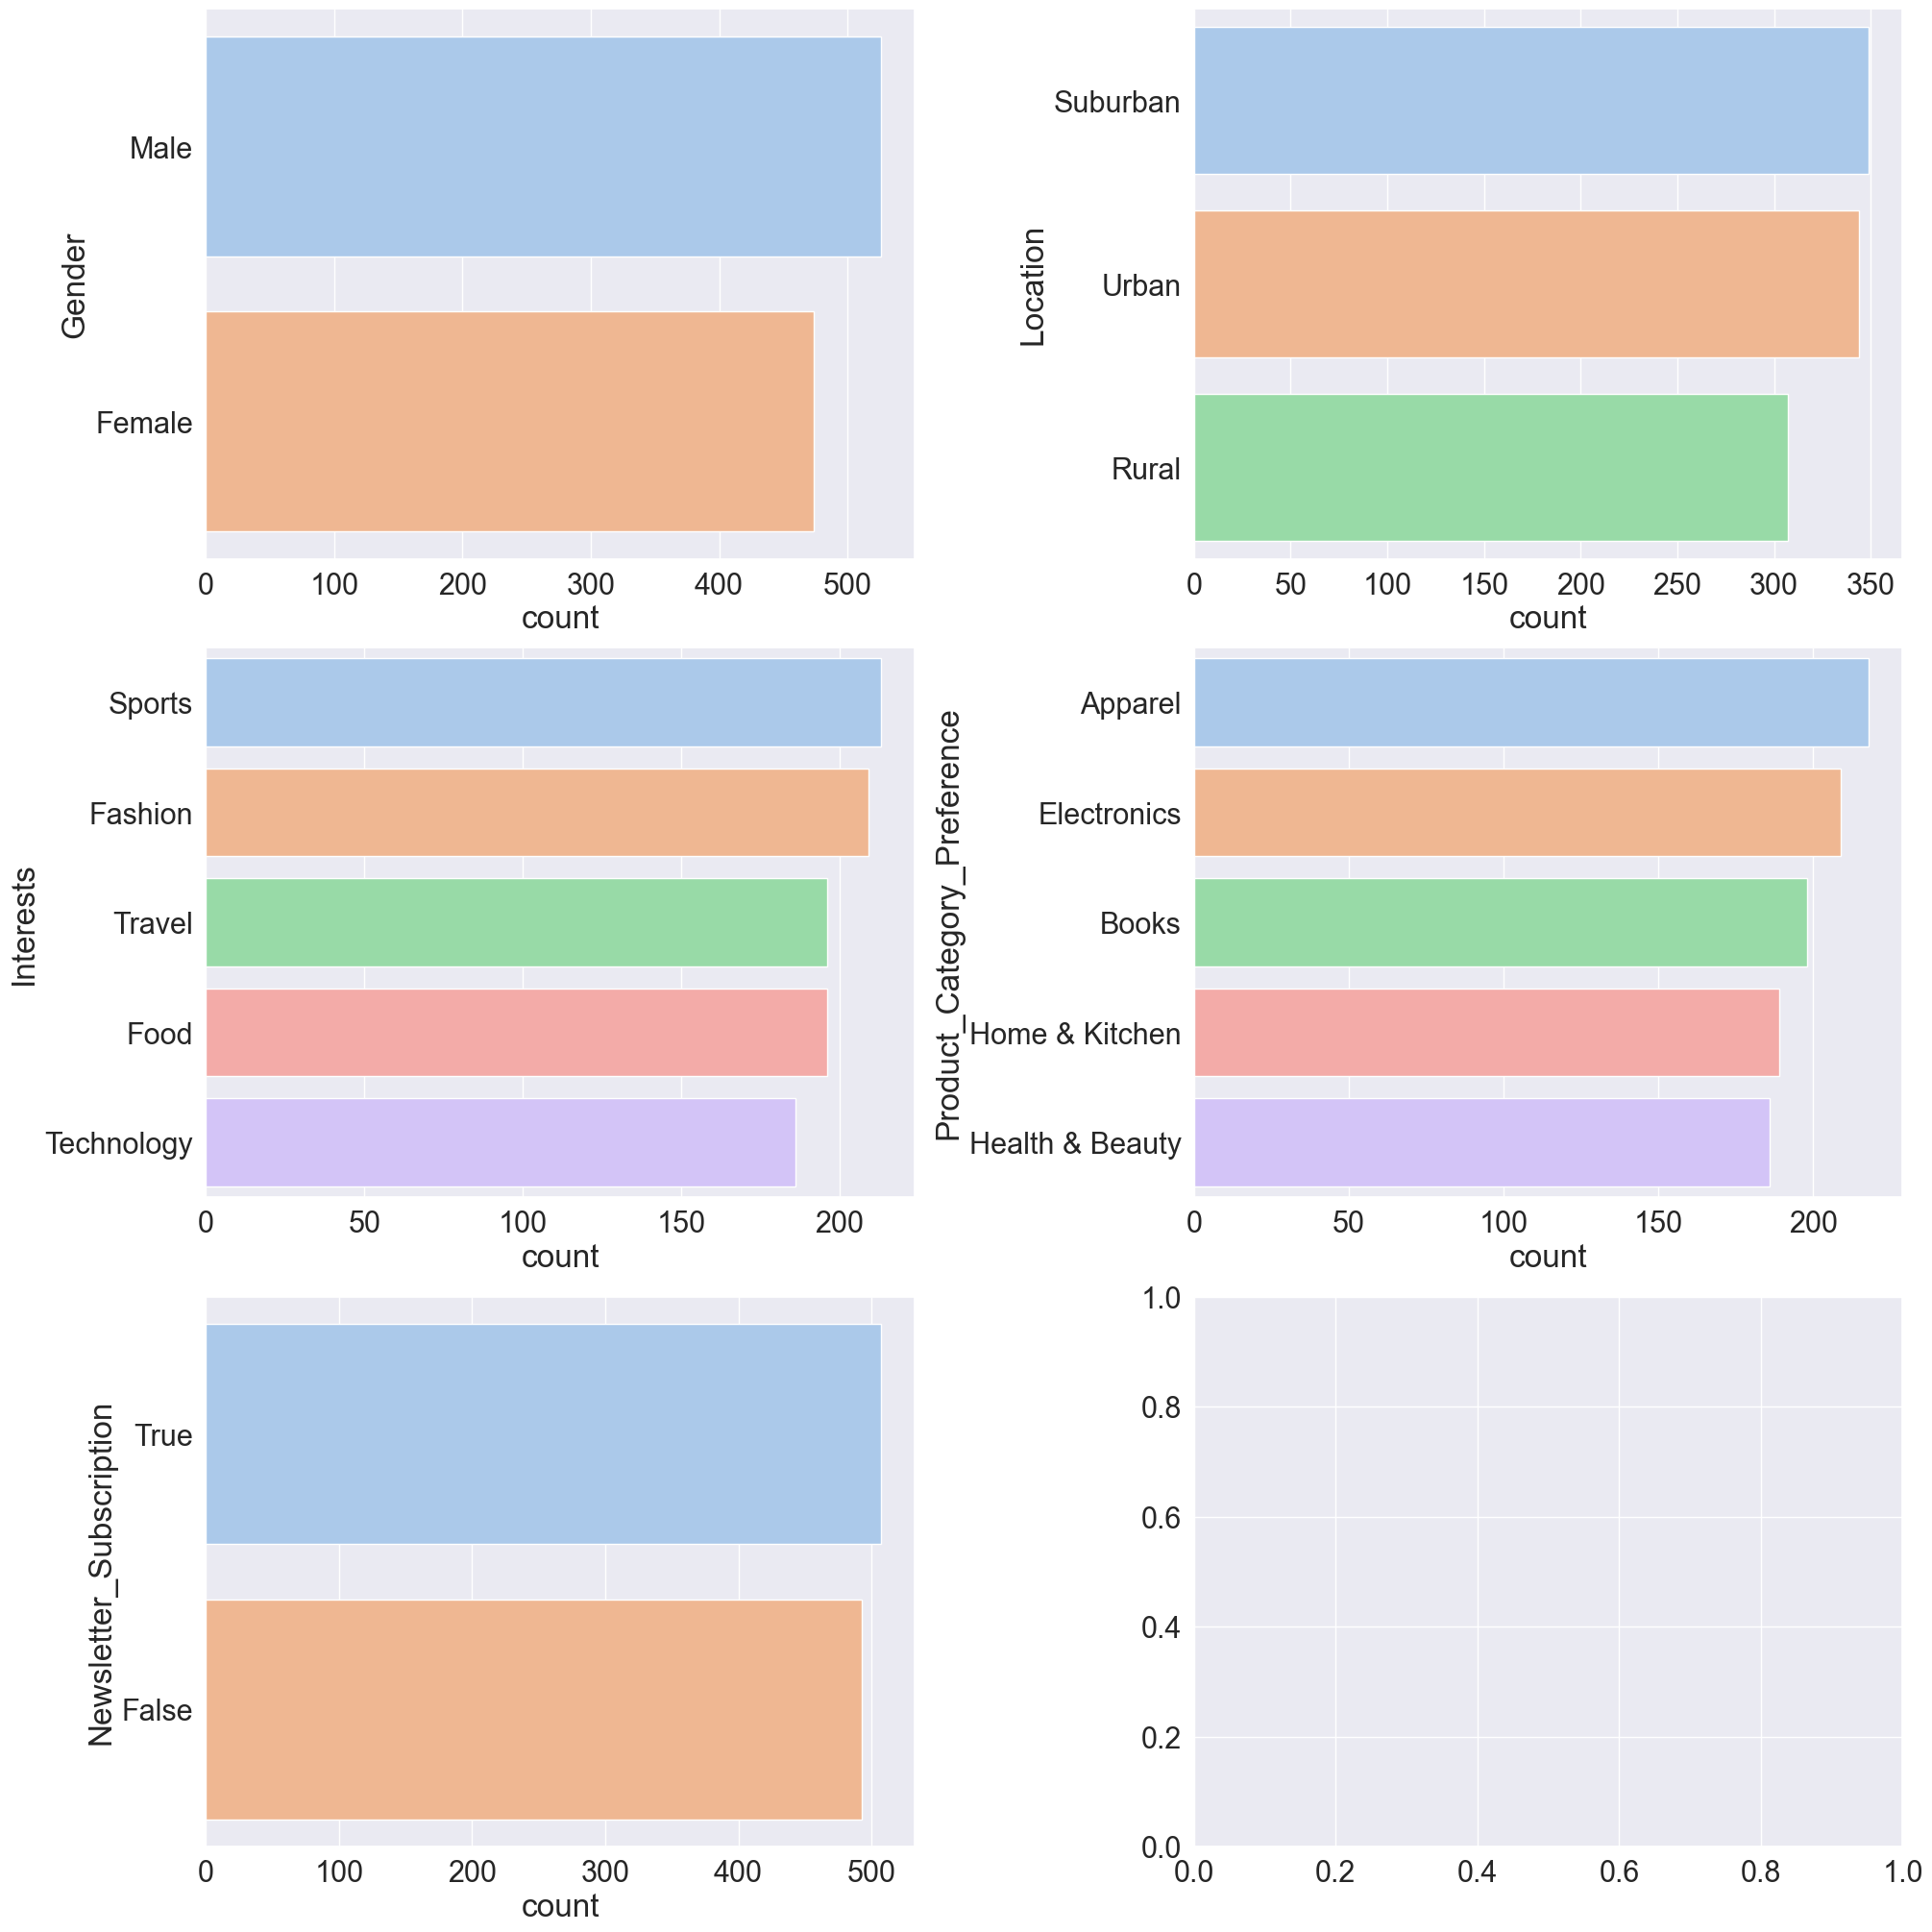

In [10]:
sns.set(font_scale=2)
fig, axs = plt.subplots(math.ceil(len(categorical)/2), 2, figsize=(20, 20), constrained_layout=True)

for i, f in enumerate(categorical):
    sns.countplot(y=f, data=df,
                  ax=axs[i//2][i % 2],
                  order=df[f].value_counts().index, palette='pastel')

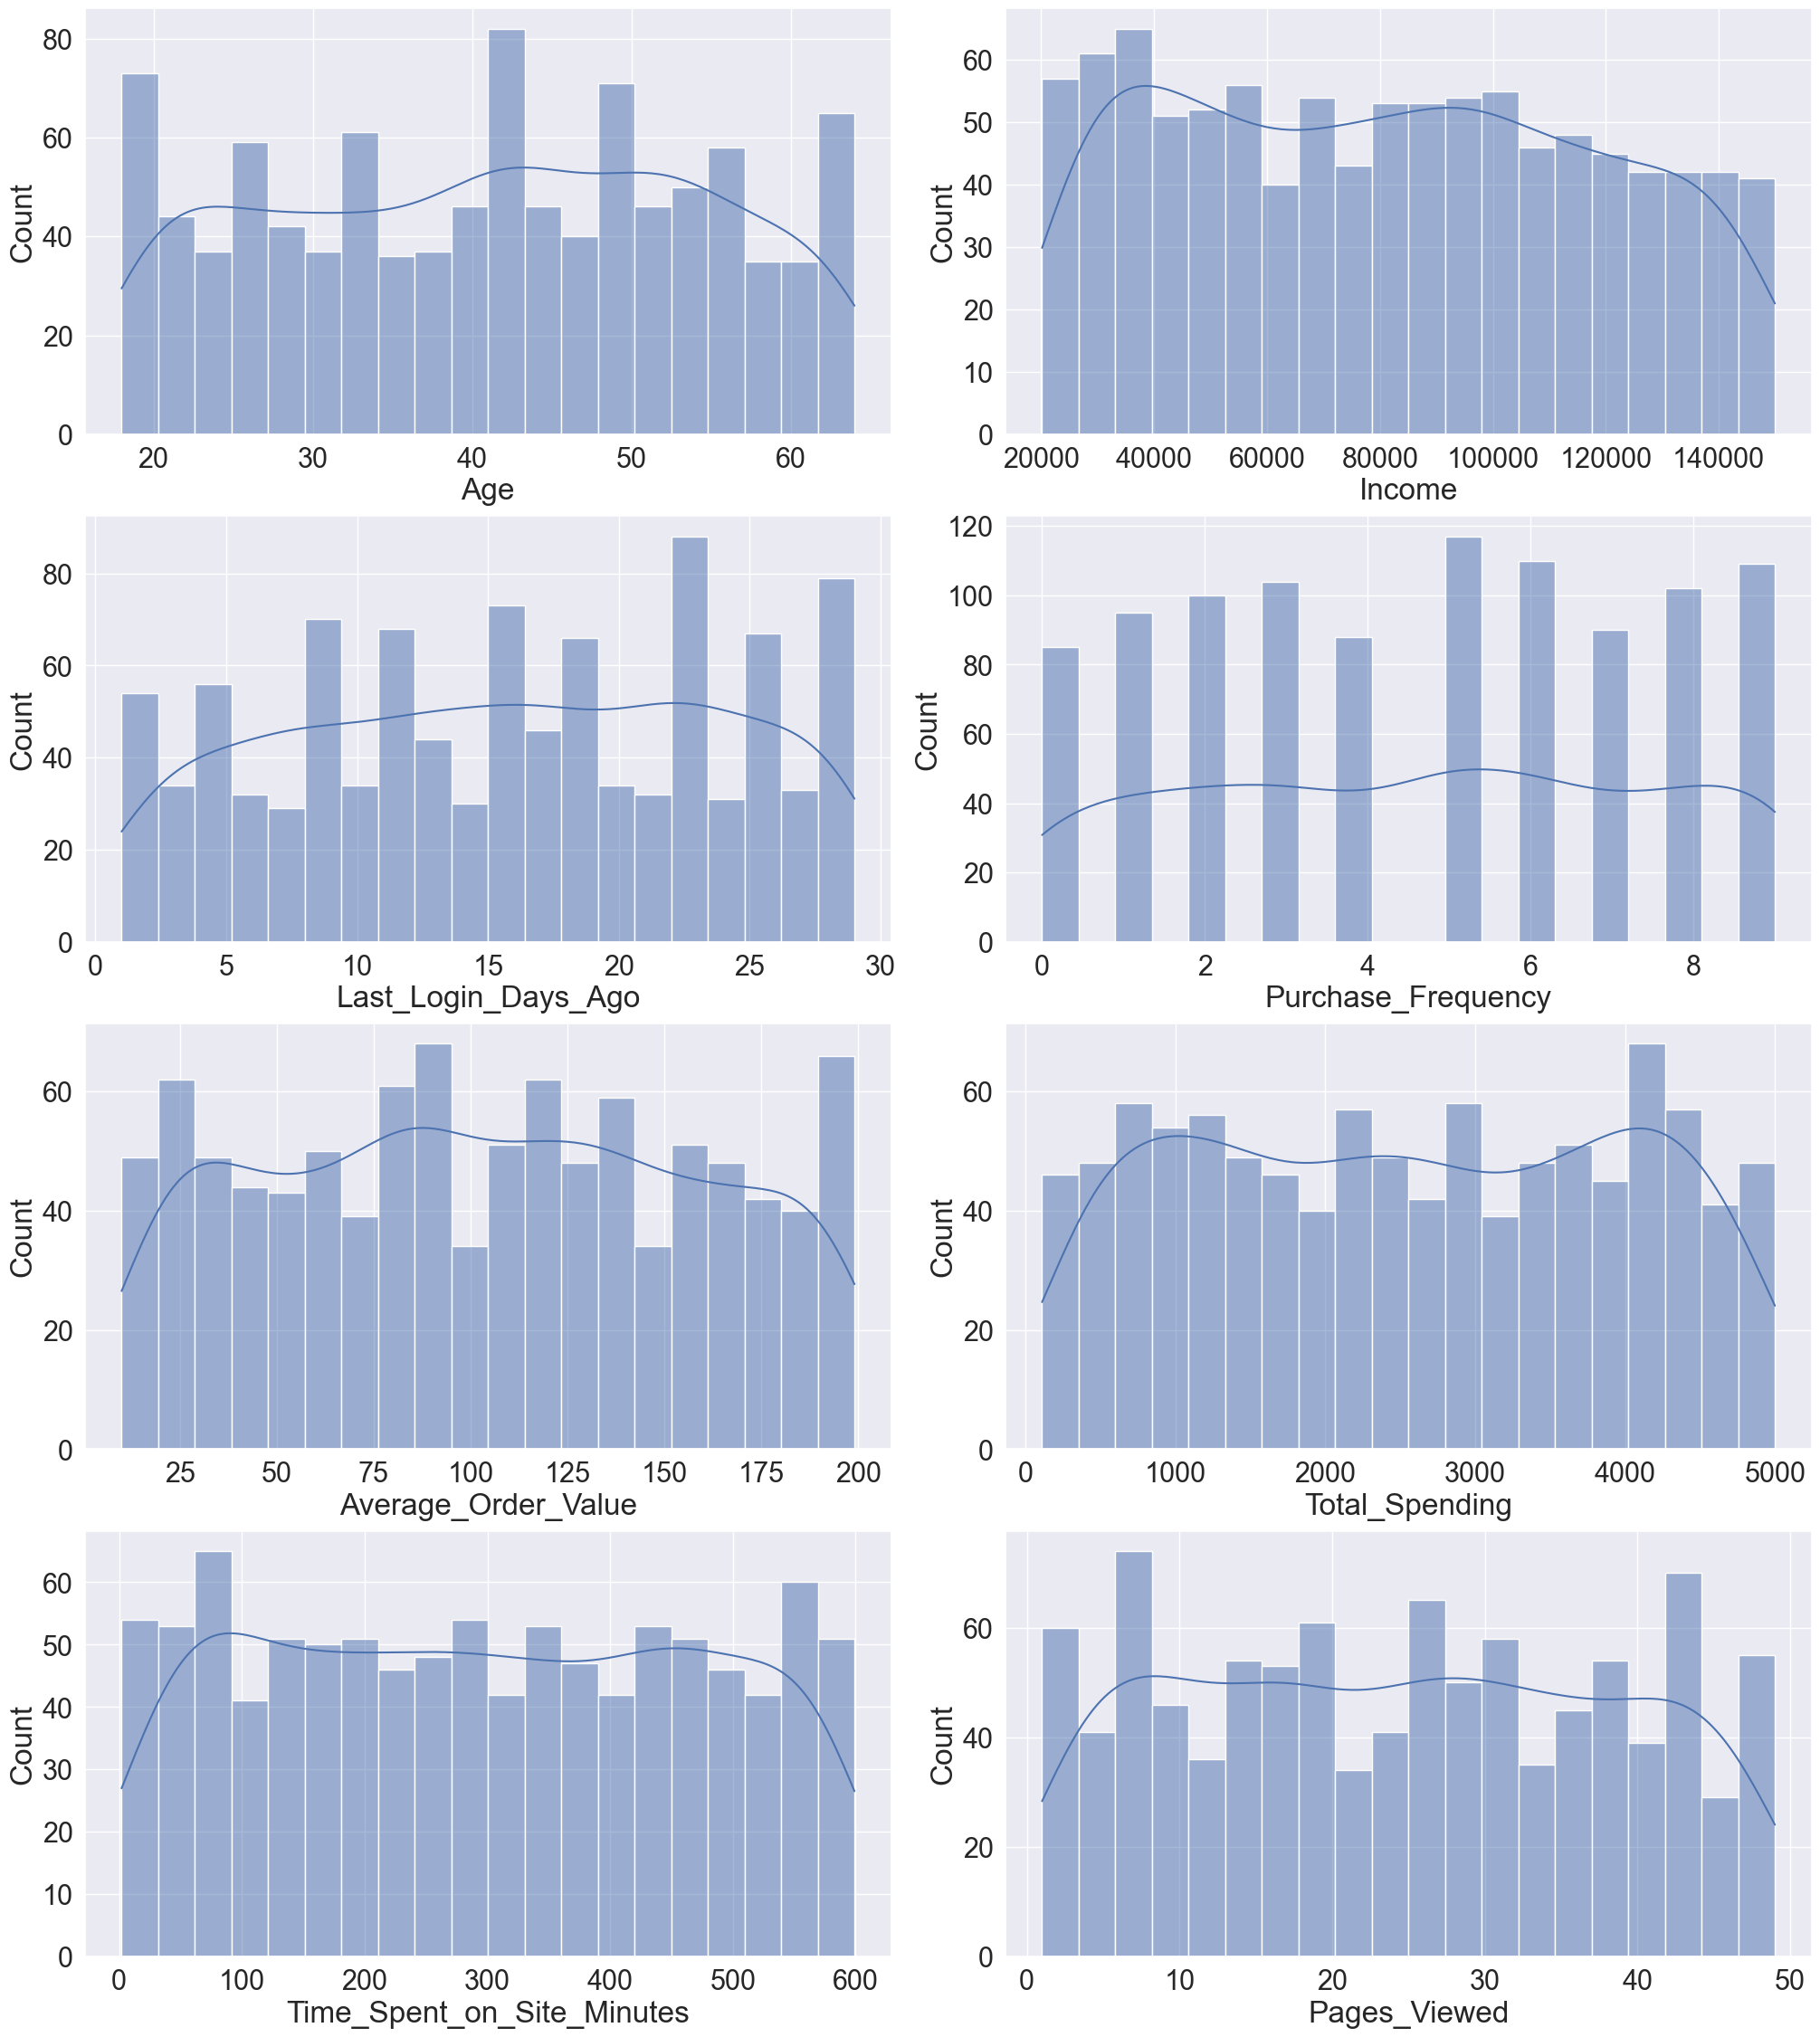

In [11]:
fig, axs = plt.subplots(math.ceil(len(numerical)/2), 2, figsize=(20, 2.8*(len(numerical))), constrained_layout=True)

for i, f in enumerate(numerical):
    sns.histplot(x=f, data=df, kde=True,
                 ax=axs[i//2][i % 2],
                 bins=20)

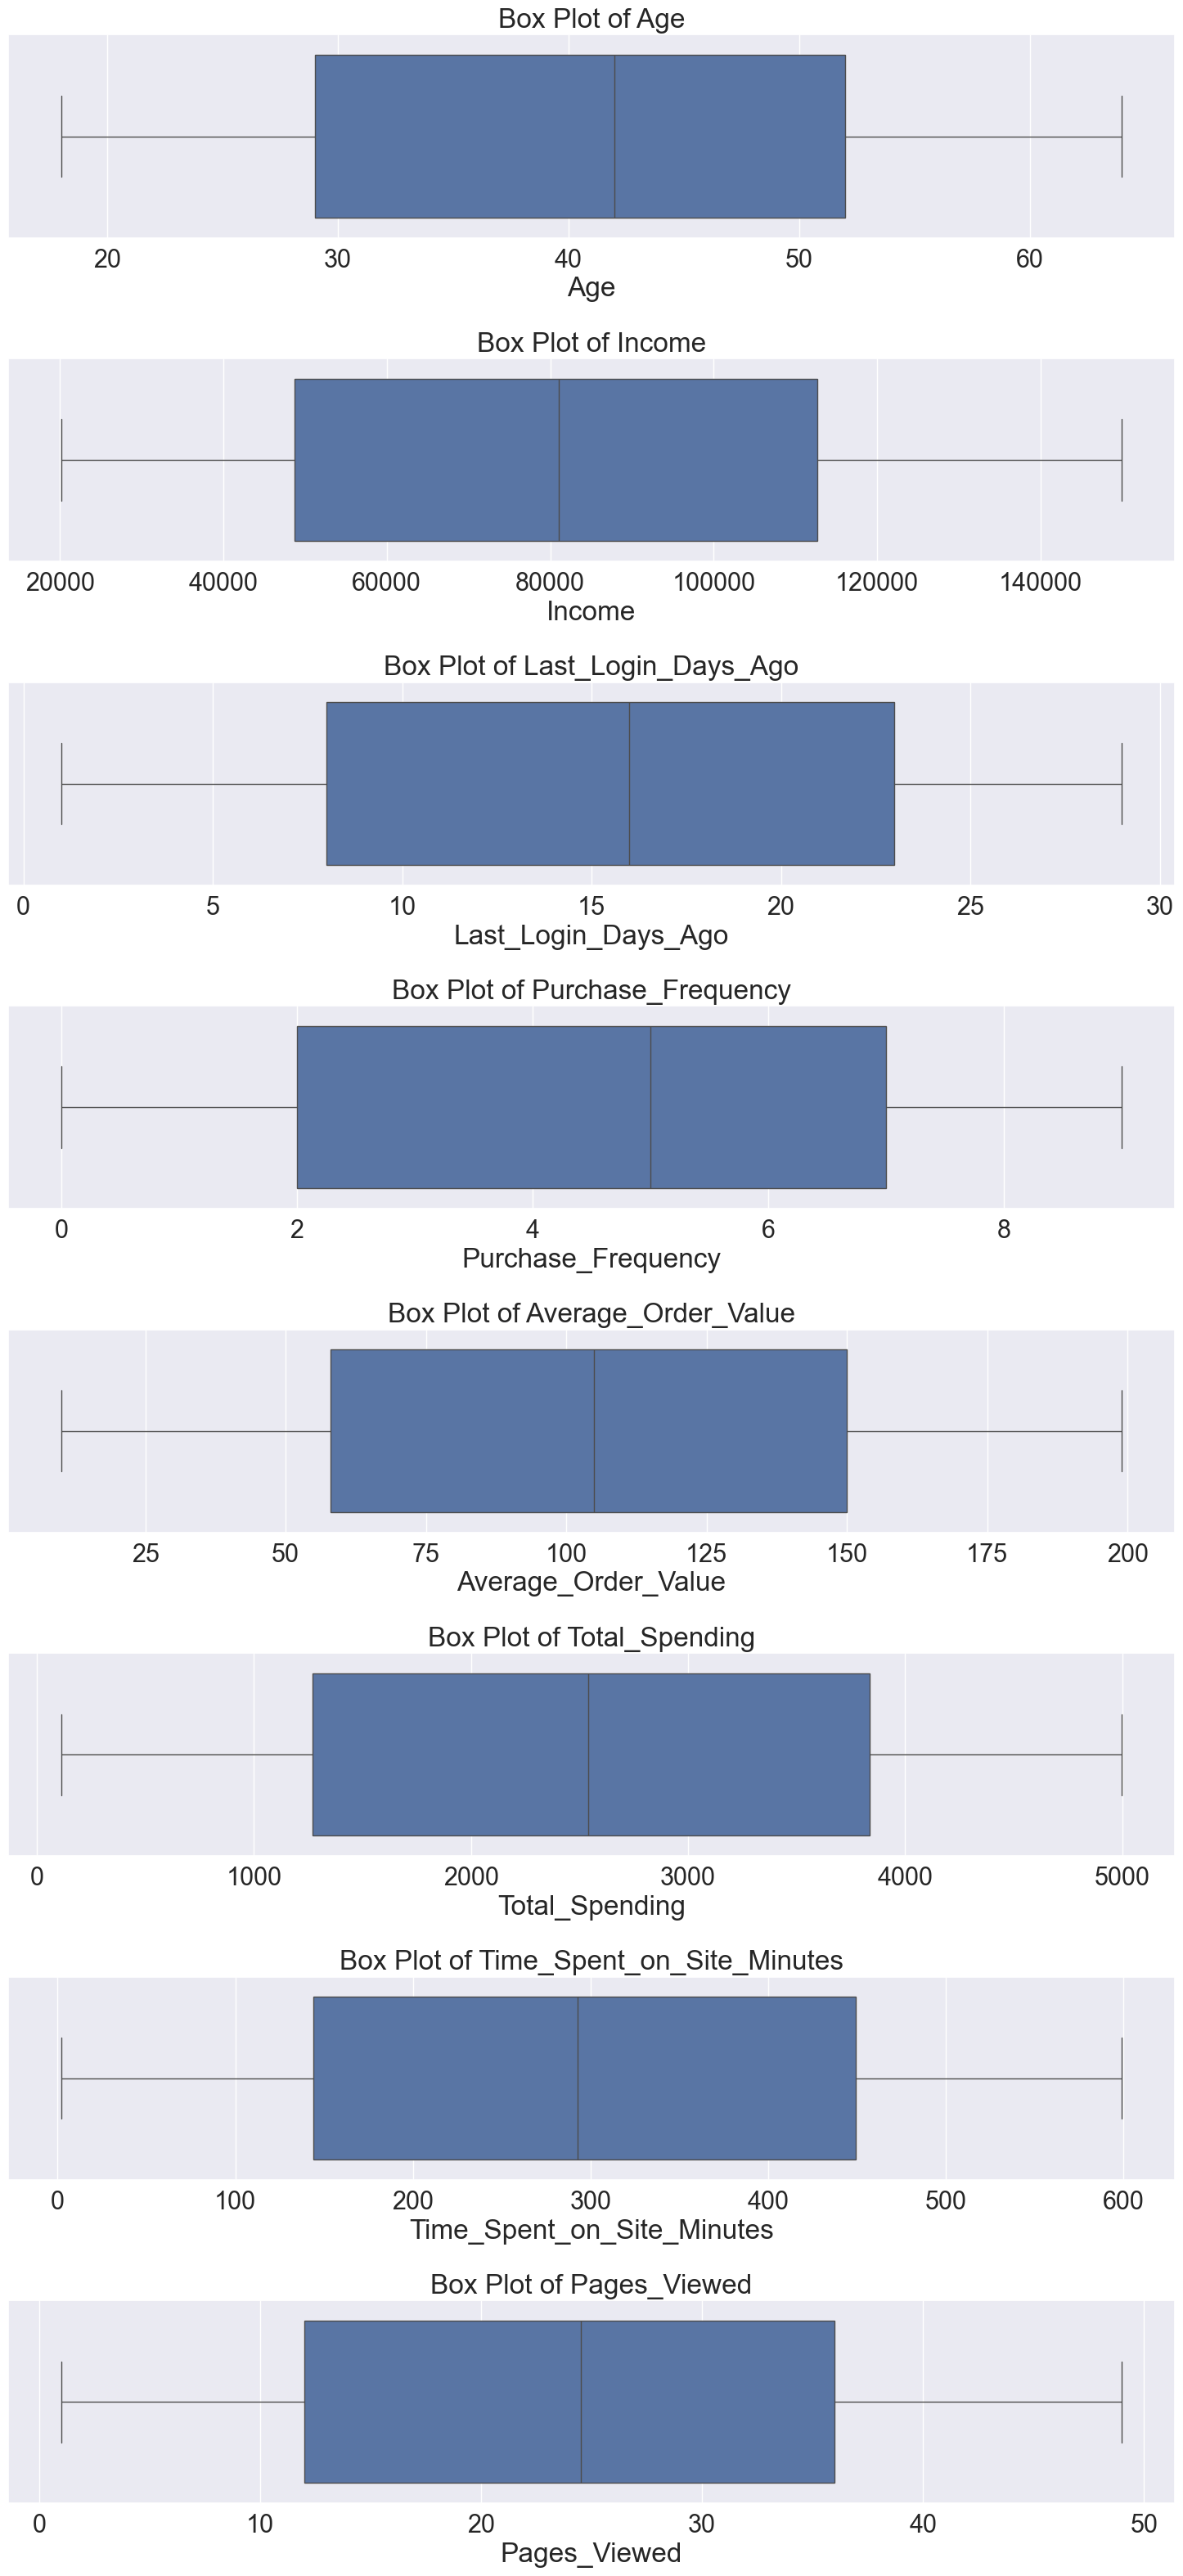

In [12]:
plt.figure(figsize=(15, len(numerical) * 4))

for i, col in enumerate(numerical, 1):
    plt.subplot(len(numerical), 1, i)
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

In [13]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

for col in numerical:
    outliers = detect_outliers(df, col)
    print(f'Outliers in {col}:')
    print(outliers if not outliers.empty else "No outliers found.")
    print('-' * 50)

Outliers in Age:
No outliers found.
--------------------------------------------------
Outliers in Income:
No outliers found.
--------------------------------------------------
Outliers in Last_Login_Days_Ago:
No outliers found.
--------------------------------------------------
Outliers in Purchase_Frequency:
No outliers found.
--------------------------------------------------
Outliers in Average_Order_Value:
No outliers found.
--------------------------------------------------
Outliers in Total_Spending:
No outliers found.
--------------------------------------------------
Outliers in Time_Spent_on_Site_Minutes:
No outliers found.
--------------------------------------------------
Outliers in Pages_Viewed:
No outliers found.
--------------------------------------------------


## Kodiranje kategorickih vrednosti

In [14]:
for key in categorical:
    print(key + ':\n', df[key].unique())

Gender:
 ['Male' 'Female']
Location:
 ['Suburban' 'Rural' 'Urban']
Interests:
 ['Sports' 'Technology' 'Fashion' 'Travel' 'Food']
Product_Category_Preference:
 ['Books' 'Electronics' 'Apparel' 'Health & Beauty' 'Home & Kitchen']
Newsletter_Subscription:
 [ True False]


In [15]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Newsletter_Subscription'] = df['Newsletter_Subscription'].map({False:0, True:1})

df.head()

,Age,Gender,Location,Income,Interests,Last_Login_Days_Ago,Purchase_Frequency,Average_Order_Value,Total_Spending,Product_Category_Preference,Time_Spent_on_Site_Minutes,Pages_Viewed,Newsletter_Subscription
0,56,0,Suburban,38037,Sports,5,7,18,2546,Books,584,38,1
1,46,1,Rural,103986,Technology,15,7,118,320,Electronics,432,40,0
2,32,1,Suburban,101942,Sports,28,1,146,3766,Apparel,306,1,1
3,60,1,Suburban,71612,Fashion,18,3,163,4377,Apparel,527,29,0
4,25,0,Suburban,49725,Travel,2,5,141,4502,Health & Beauty,53,10,1


In [16]:
label_encoder_location = LabelEncoder()
label_encoder_interests = LabelEncoder()
label_encoder_product = LabelEncoder()

df['Location'] = label_encoder_location.fit_transform(df['Location'])
df['Interests'] = label_encoder_interests.fit_transform(df['Interests'])
df['Product_Category_Preference'] = label_encoder_product.fit_transform(df['Product_Category_Preference'])

df.head()

,Age,Gender,Location,Income,Interests,Last_Login_Days_Ago,Purchase_Frequency,Average_Order_Value,Total_Spending,Product_Category_Preference,Time_Spent_on_Site_Minutes,Pages_Viewed,Newsletter_Subscription
0,56,0,1,38037,2,5,7,18,2546,1,584,38,1
1,46,1,0,103986,3,15,7,118,320,2,432,40,0
2,32,1,1,101942,2,28,1,146,3766,0,306,1,1
3,60,1,1,71612,0,18,3,163,4377,0,527,29,0
4,25,0,1,49725,4,2,5,141,4502,3,53,10,1


In [17]:
for key in categorical:
    print(key + ':\n', df[key].unique())

Gender:
 [0 1]
Location:
 [1 0 2]
Interests:
 [2 3 0 4 1]
Product_Category_Preference:
 [1 2 0 3 4]
Newsletter_Subscription:
 [1 0]


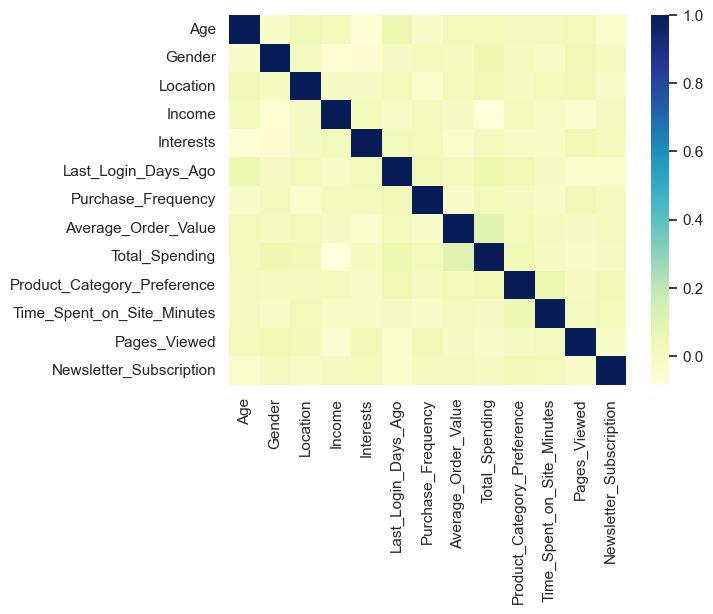

In [18]:
sns.set(font_scale=1)
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap="YlGnBu", fmt='g')
plt.show()

In [19]:
scaler = StandardScaler()
df[numerical] = scaler.fit_transform(df[numerical])

## Klasterizacija

In [20]:
def visualize_clusters(data, labels, title):
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='Set1', legend='full')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

def visualize_clusters_3d(data, labels, title):
    pca = PCA(n_components=3)
    data_pca = pca.fit_transform(data)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=labels, cmap='Set1')
    legend = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend)
    
    plt.title(title)
    plt.show()

def print_feature_importance(df, pred, centers=None):
    if centers is None:
        cluster_means = df.groupby(pred).mean()
    else:
        cluster_means = pd.DataFrame(centers, columns=df.columns)
    fig, ax = plt.subplots(figsize=(16, 6))
    cluster_means.T.plot(kind='bar', ax=ax, cmap='Set1')
    plt.title('Feature importance')
    plt.show()

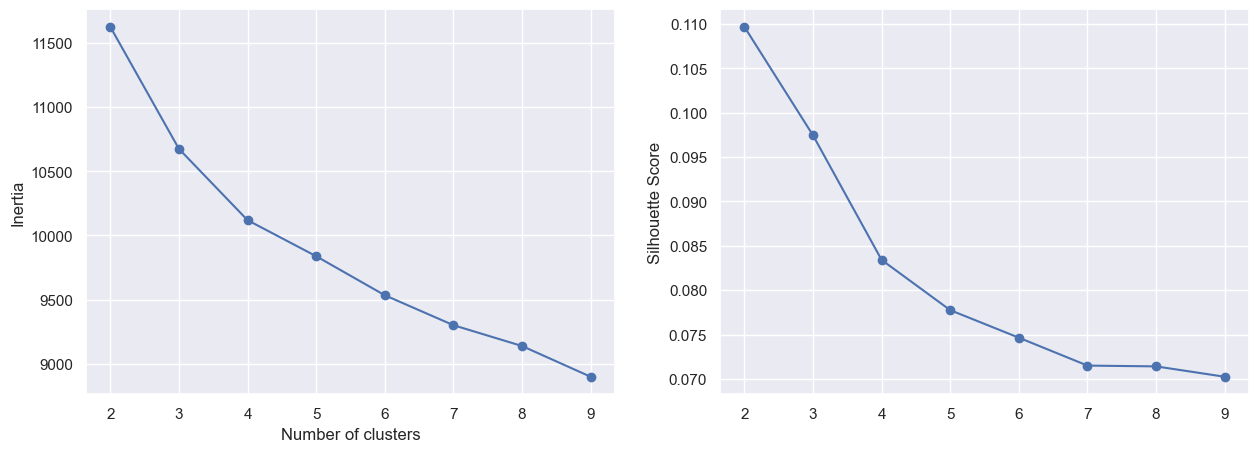

In [21]:
k_range = range(2, 10)
inertia = []
silhouette = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)
    silhouette.append(metrics.silhouette_score(df, kmeans.labels_))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette, marker='o')
plt.ylabel('Silhouette Score')

plt.show()

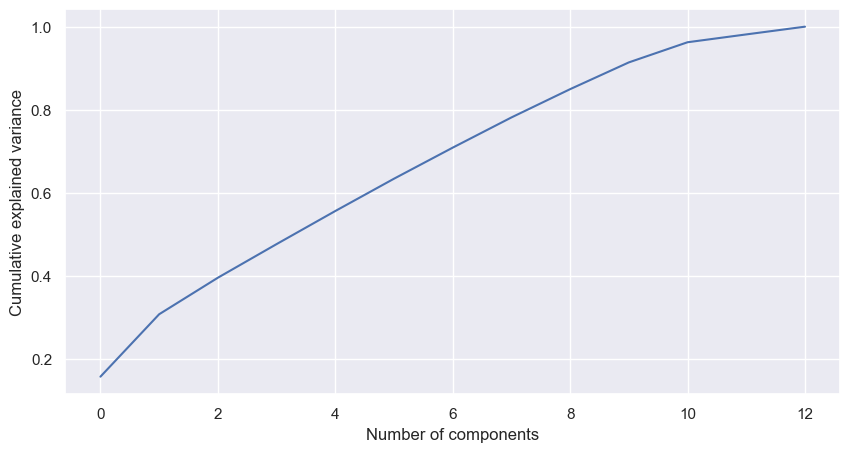

In [46]:
pca = PCA()
pca.fit(df)
data_pca = pca.transform(df)

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

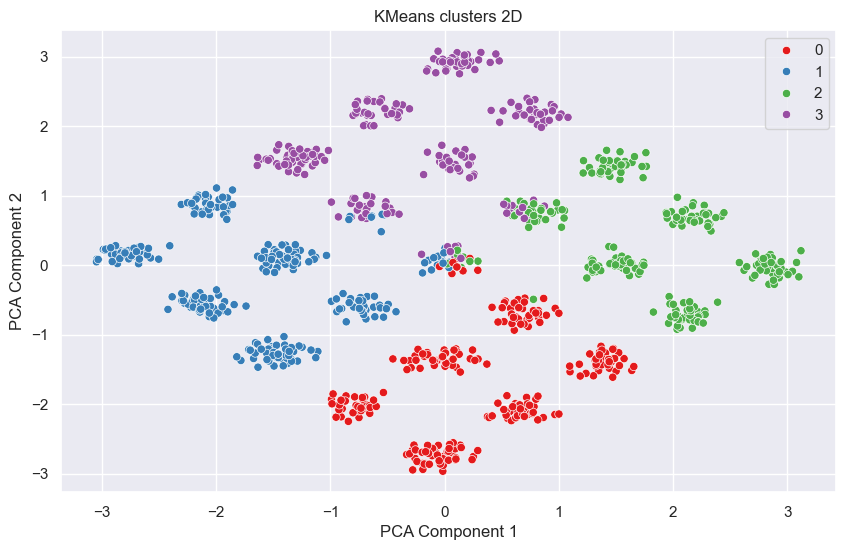

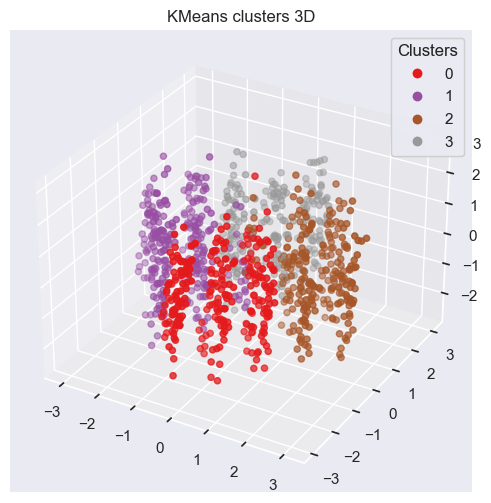

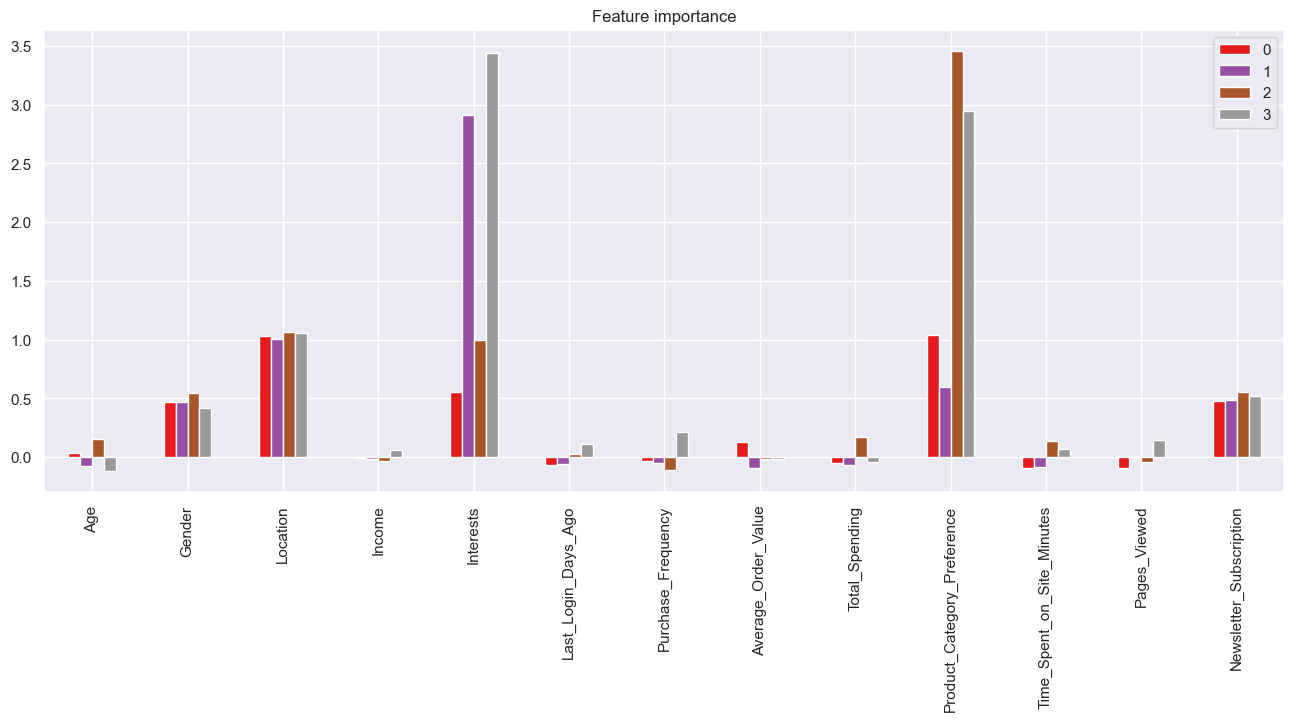

In [22]:
results = []

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(df)

visualize_clusters(df, kmeans_labels, "KMeans clusters 2D")
visualize_clusters_3d(df, kmeans_labels, "KMeans clusters 3D")
print_feature_importance(df, kmeans_labels, centers=kmeans.cluster_centers_)

silhouette_score = metrics.silhouette_score(df, kmeans_labels)
ch_score = metrics.calinski_harabasz_score(df, kmeans_labels)
db_score = metrics.davies_bouldin_score(df, kmeans_labels)

results.append({
                "Model": "KMeans",
                "Silhouette score": silhouette_score,
                "CH score": ch_score,
                "DB score": db_score,
            })

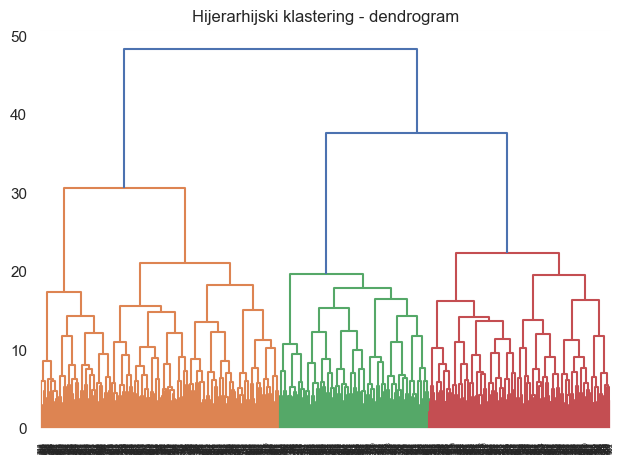

In [23]:
linkage_matrix = linkage(df, "ward")
dendrogram(linkage_matrix, p=4, color_threshold=None)
plt.title("Hijerarhijski klastering - dendrogram")
plt.tight_layout()
plt.show()

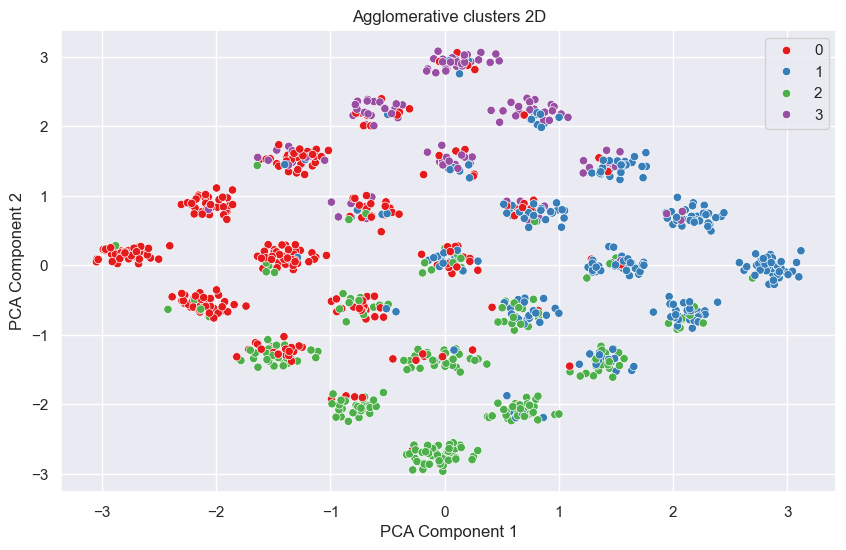

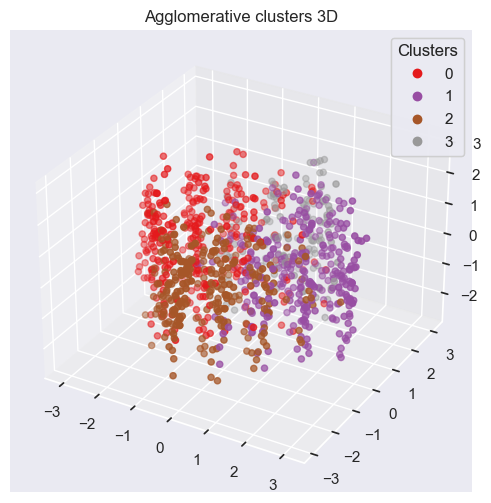

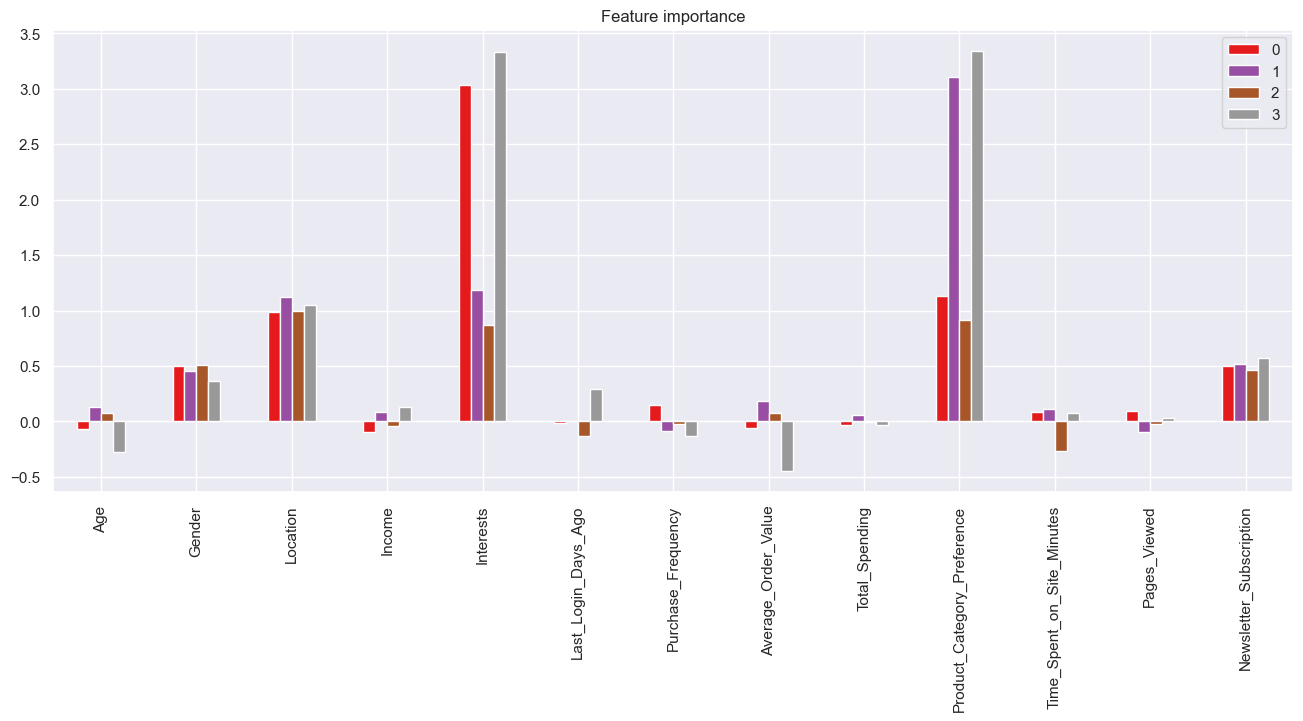

In [24]:
agglo = AgglomerativeClustering(n_clusters=4, linkage='ward')
agglo_labels = agglo.fit_predict(df)

visualize_clusters(df, agglo_labels, "Agglomerative clusters 2D")
visualize_clusters_3d(df, agglo_labels, "Agglomerative clusters 3D")
print_feature_importance(df, agglo_labels)

silhouette_score = metrics.silhouette_score(df, agglo_labels)
ch_score = metrics.calinski_harabasz_score(df, agglo_labels)
db_score = metrics.davies_bouldin_score(df, agglo_labels)

results.append({
                "Model": "Agglomerative",
                "Silhouette score": silhouette_score,
                "CH score": ch_score,
                "DB score": db_score,
            })

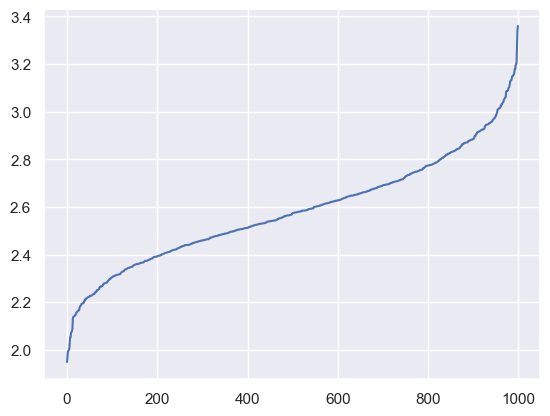

In [25]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)

distances = np.sort(distances[:, 3], axis=0)
plt.plot(distances)
plt.show()

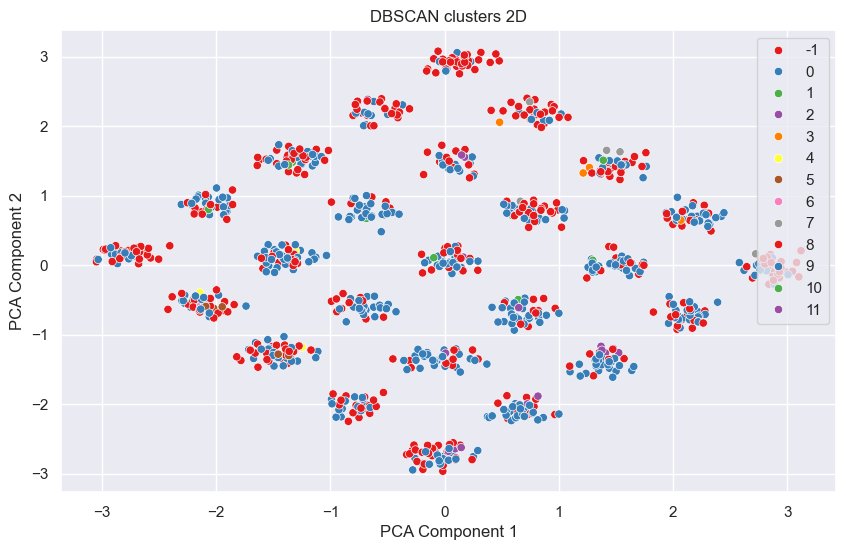

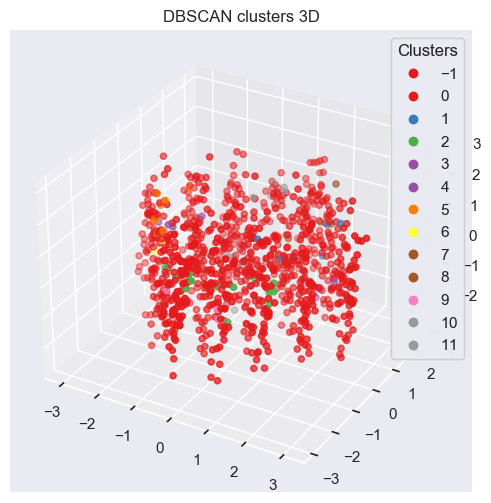

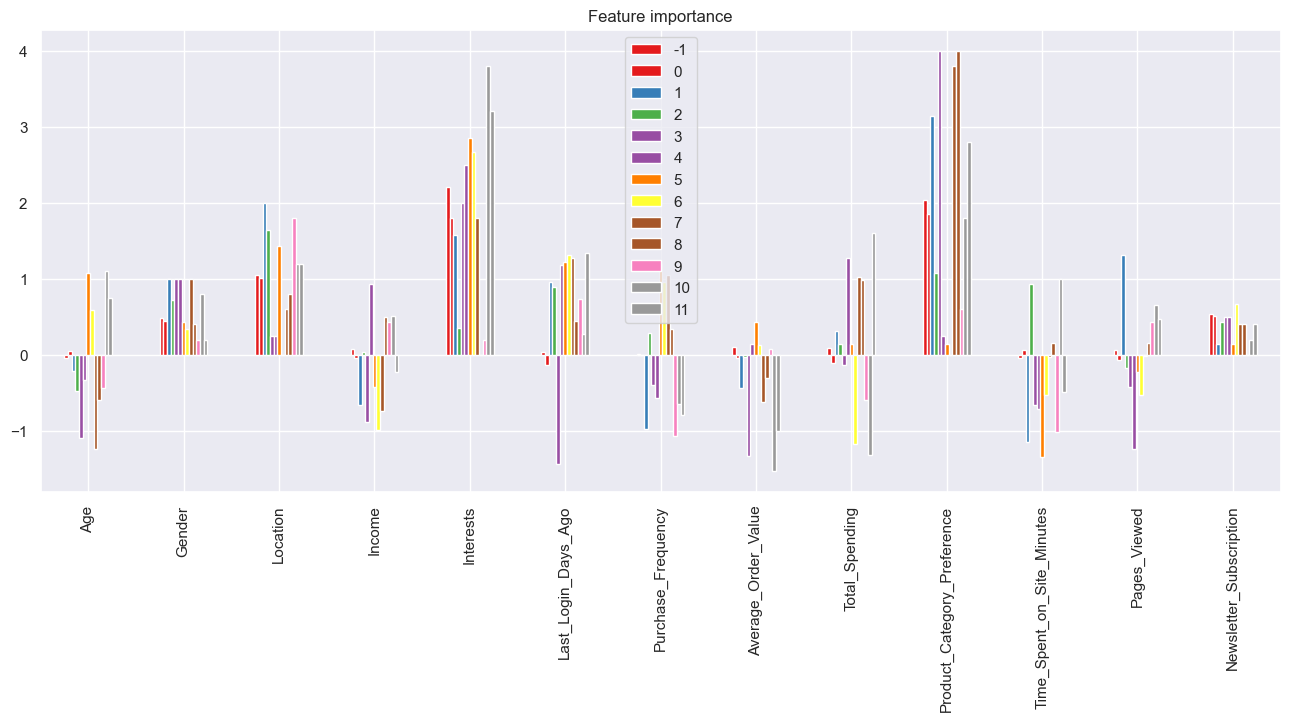

In [26]:
dbscan = DBSCAN(eps=2.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df)

visualize_clusters(df, dbscan_labels, "DBSCAN clusters 2D")
visualize_clusters_3d(df, dbscan_labels, "DBSCAN clusters 3D")
print_feature_importance(df, dbscan_labels)

silhouette_score = metrics.silhouette_score(df, dbscan_labels)
ch_score = metrics.calinski_harabasz_score(df, dbscan_labels)
db_score = metrics.davies_bouldin_score(df, dbscan_labels)

results.append({
                "Model": "DBSCAN",
                "Silhouette score": silhouette_score,
                "CH score": ch_score,
                "DB score": db_score,
            })

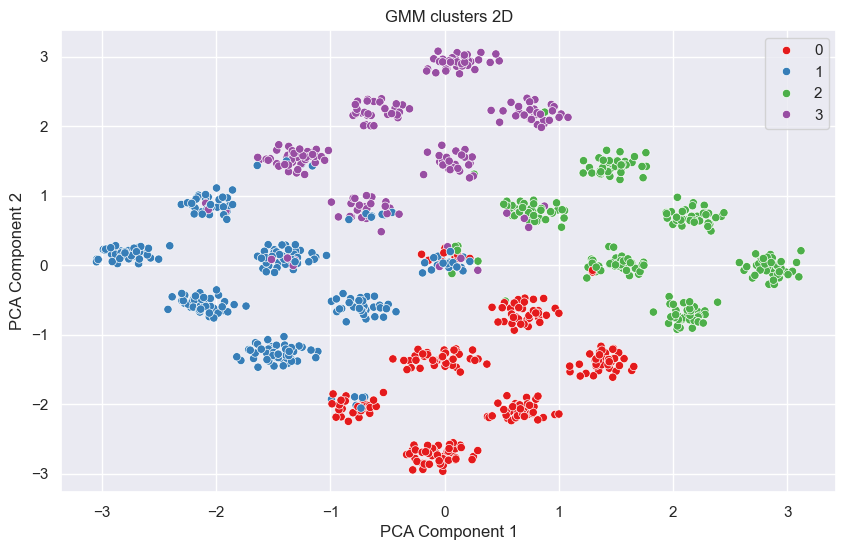

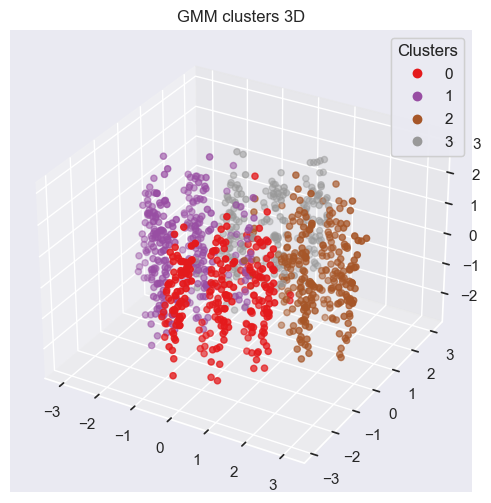

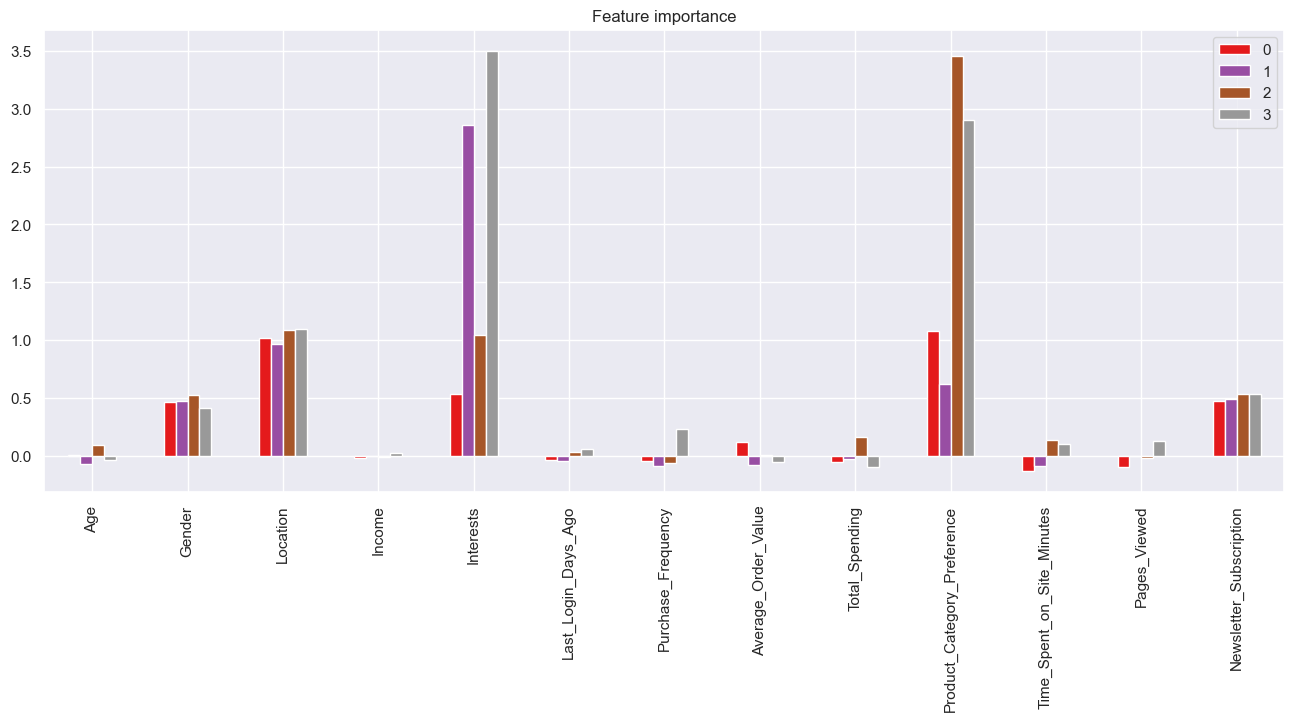

In [27]:
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(df)

visualize_clusters(df, gmm_labels, "GMM clusters 2D")
visualize_clusters_3d(df, gmm_labels, "GMM clusters 3D")
print_feature_importance(df, gmm_labels)

silhouette_score = metrics.silhouette_score(df, gmm_labels)
ch_score = metrics.calinski_harabasz_score(df, gmm_labels)
db_score = metrics.davies_bouldin_score(df, gmm_labels)

results.append({
                "Model": "GMM",
                "Silhouette score": silhouette_score,
                "CH score": ch_score,
                "DB score": db_score,
            })

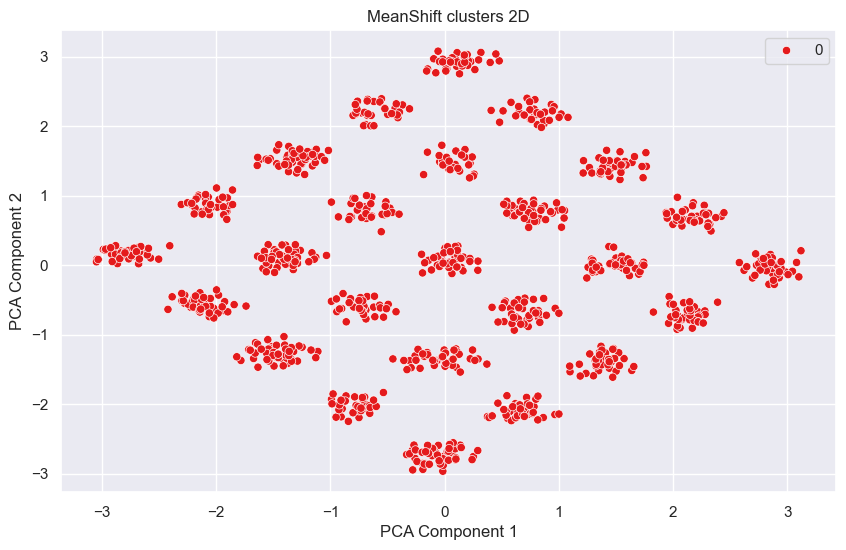

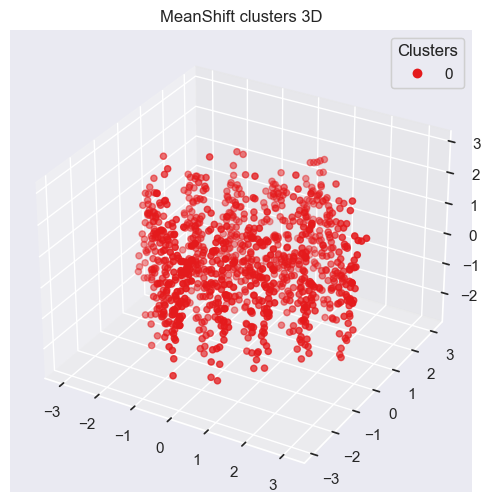

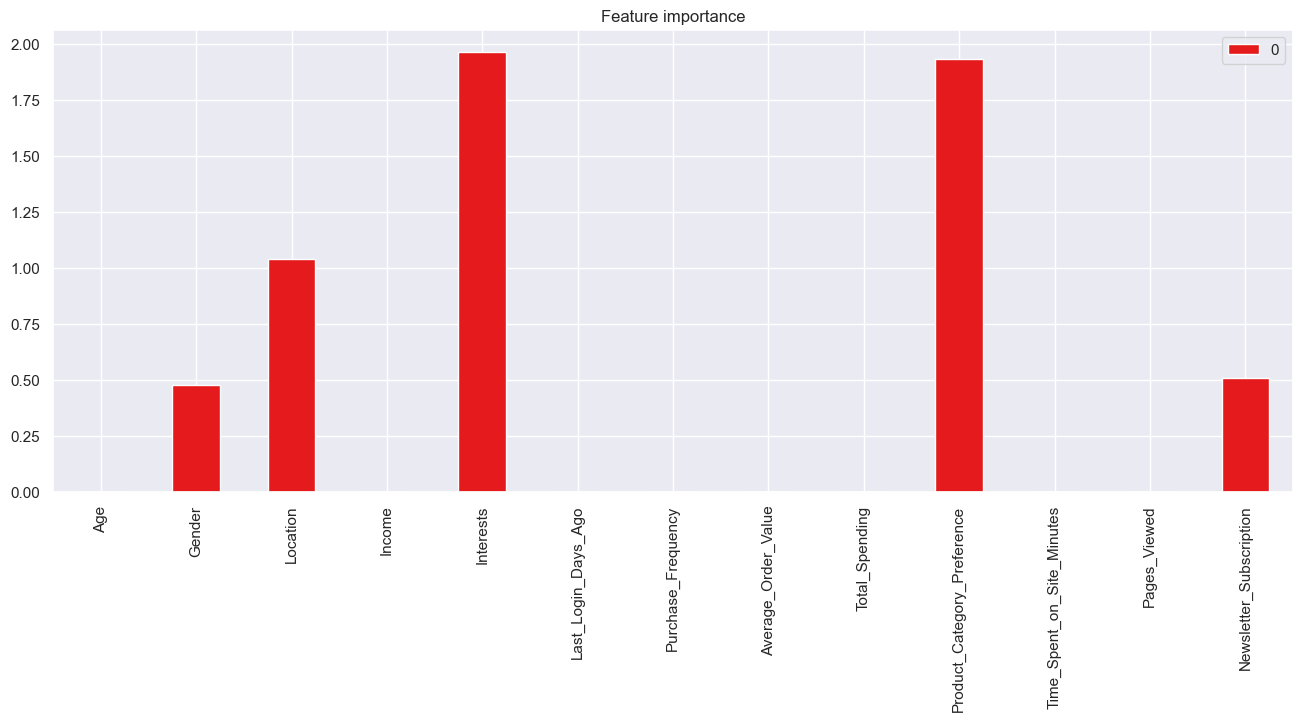

In [31]:
bandwidth = estimate_bandwidth(df, quantile=0.2, n_samples=500)

meanshift = MeanShift(bandwidth=bandwidth)
meanshift_labels = meanshift.fit_predict(df)

visualize_clusters(df, meanshift_labels, "MeanShift clusters 2D")
visualize_clusters_3d(df, meanshift_labels, "MeanShift clusters 3D")
print_feature_importance(df, meanshift_labels)

# silhouette_score = metrics.silhouette_score(df, meanshift_labels)
# ch_score = metrics.calinski_harabasz_score(df, meanshift_labels)
# db_score = metrics.davies_bouldin_score(df, meanshift_labels)

# results.append({
#                 "Model": "MeanShift",
#                 "Silhouette score": silhouette_score,
#                 "CH score": ch_score,
#                 "DB score": db_score,
#             })

In [308]:
results_df = pd.DataFrame(results)
results_df

,Model,Silhouette score,CH score,DB score
0,KMeans,0.083412,99.639552,2.580093
1,Agglomerative,0.052845,72.275113,2.880990
2,DBSCAN,-0.189808,4.454120,3.408706
3,GMM,0.079400,96.794440,2.627599


KMeans i GMM su postigli najbolje rezultate prema svim metrikama (visoki CH i niski DB score), što sugeriše da su to najbolji algoritmi za ove konkretne podatke. DBSCAN i Agglomerative se nisu se dobro pokazali, posebno DBSCAN, koji je dao loše rezultate prema svim metrikama. Za MeanShift metrike nisu ni izracunate jer nalazi samo jedan klaster.

In [309]:
df['labels'] = kmeans_labels

df['Gender'] = df['Gender'].map({0: 'Male', 1: 'Female'})
df['Newsletter_Subscription'] = df['Newsletter_Subscription'].map({0: False, 1: True})

df['Location'] = label_encoder_location.inverse_transform(df['Location'])
df['Interests'] = label_encoder_interests.inverse_transform(df['Interests'])
df['Product_Category_Preference'] = label_encoder_product.inverse_transform(df['Product_Category_Preference'])

df.head()

,Age,Gender,Location,Income,Interests,Last_Login_Days_Ago,Purchase_Frequency,Average_Order_Value,Total_Spending,Product_Category_Preference,Time_Spent_on_Site_Minutes,Pages_Viewed,Newsletter_Subscription,labels
0,1.112882,Male,Suburban,-1.158586,Sports,-1.290739,0.835231,-1.568734,-0.004898,Books,1.633199,0.970302,True,1
1,0.371652,Female,Rural,0.607340,Technology,-0.071450,0.835231,0.254549,-1.572201,Electronics,0.767143,1.113025,False,3
2,-0.666069,Female,Suburban,0.552607,Sports,1.513626,-1.280170,0.765068,0.854091,Apparel,0.049228,-1.670073,True,1
3,1.409373,Female,Suburban,-0.259544,Fashion,0.294336,-0.575036,1.075026,1.284289,Apparel,1.308428,0.328049,False,0
4,-1.184929,Male,Suburban,-0.845615,Travel,-1.656526,0.130097,0.673904,1.372300,Health & Beauty,-1.392299,-1.027820,True,3


In [310]:
df[numerical] = scaler.inverse_transform(df[numerical])
df.head()

,Age,Gender,Location,Income,Interests,Last_Login_Days_Ago,Purchase_Frequency,Average_Order_Value,Total_Spending,Product_Category_Preference,Time_Spent_on_Site_Minutes,Pages_Viewed,Newsletter_Subscription,labels
0,56.0,Male,Suburban,38037.0,Sports,5.0,7.0,18.0,2546.0,Books,584.0,38.0,True,1
1,46.0,Female,Rural,103986.0,Technology,15.0,7.0,118.0,320.0,Electronics,432.0,40.0,False,3
2,32.0,Female,Suburban,101942.0,Sports,28.0,1.0,146.0,3766.0,Apparel,306.0,1.0,True,1
3,60.0,Female,Suburban,71612.0,Fashion,18.0,3.0,163.0,4377.0,Apparel,527.0,29.0,False,0
4,25.0,Male,Suburban,49725.0,Travel,2.0,5.0,141.0,4502.0,Health & Beauty,53.0,10.0,True,3


## Analiza dobijenih klastera

In [311]:
def analyze_clusters(df, cluster_col):
    analysis = {}
    clusters = df[cluster_col].unique()
    
    for cluster in clusters:
        cluster_data = df[df[cluster_col] == cluster]
        
        analysis[cluster] = {}
        analysis[cluster]['Prosečno vreme na sajtu'] = cluster_data['Time_Spent_on_Site_Minutes'].mean()
        analysis[cluster]['Ukupna potrošnja'] = cluster_data['Total_Spending'].mean()
        analysis[cluster]['Prosečan broj godina'] = cluster_data['Age'].mean()
        analysis[cluster]['Prosečna zarada'] = cluster_data['Income'].mean()
        analysis[cluster]['Prosečna vrednost narudžbine'] = cluster_data['Average_Order_Value'].mean()
        analysis[cluster]['Najčešći proizvodi'] = cluster_data['Product_Category_Preference'].mode()[0]
        analysis[cluster]['Interesi'] = cluster_data['Interests'].mode()[0]
        analysis[cluster]['Pol (većinski)'] = cluster_data['Gender'].mode()[0]
        analysis[cluster]['Najčešća lokacija'] = cluster_data['Location'].mode()[0]
    
    return analysis

cluster_analysis = analyze_clusters(df, 'labels')
for cluster, data in cluster_analysis.items():
    print(f"\nKlaster {cluster}:")
    for key, value in data.items():
        print(f"  {key}: {value}")


Klaster 1:
  Prosečno vreme na sajtu: 282.59636363636366
  Ukupna potrošnja: 2453.090909090909
  Prosečan broj godina: 39.95272727272727
  Prosečna zarada: 80826.28
  Prosečna vrednost narudžbine: 98.85090909090908
  Najčešći proizvodi: Apparel
  Interesi: Sports
  Pol (većinski): Male
  Najčešća lokacija: Suburban

Klaster 3:
  Prosečno vreme na sajtu: 309.26872246696036
  Ukupna potrošnja: 2497.409691629956
  Prosečan broj godina: 39.4273127753304
  Prosečna zarada: 83534.25550660794
  Prosečna vrednost narudžbine: 103.33480176211454
  Najčešći proizvodi: Electronics
  Interesi: Travel
  Pol (većinski): Male
  Najčešća lokacija: Suburban

Klaster 0:
  Prosečno vreme na sajtu: 280.79457364341084
  Ukupna potrošnja: 2480.7286821705425
  Prosečan broj godina: 41.507751937984494
  Prosečna zarada: 81096.41085271318
  Prosečna vrednost narudžbine: 111.15503875968992
  Najčešći proizvodi: Electronics
  Interesi: Fashion
  Pol (većinski): Male
  Najčešća lokacija: Suburban

Klaster 2:
  Pr